<a href="https://colab.research.google.com/github/josdramo/AI-Project-SEST-Alert-System/blob/main/ML's_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Iniciando entrenamiento del Sistema de Alerta Temprana...
Entrenando Regresión Logística...
Entrenando SVM...
Entrenando KNN...
Entrenando Random Forest...
Entrenando XGBoost...

RANKING FINAL (Métrica Clave: AUC-ROC)
             Modelo  Accuracy  F1-Score  AUC-ROC
            XGBoost  0.748547  0.842801 0.735131
                SVM  0.807762  0.887414 0.717220
                KNN  0.652833  0.765176 0.697023
      Random Forest  0.658448  0.773226 0.684076
Regresión Logística  0.773083  0.865146 0.591553


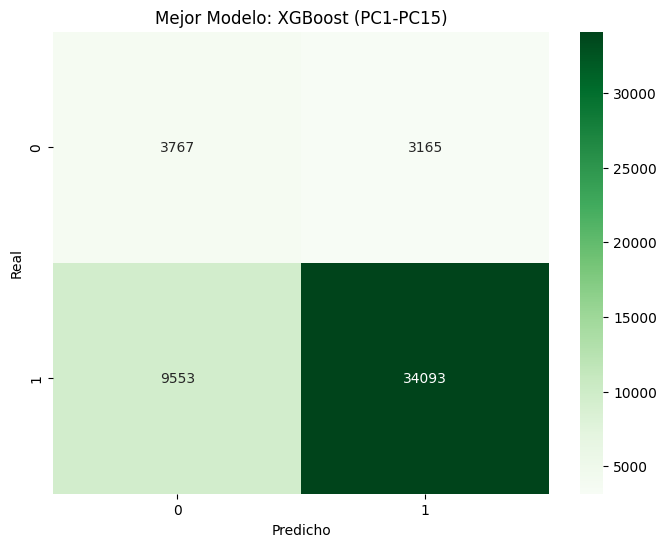


Predicciones guardadas exitosamente usando XGBoost.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score

# 1. Configuración de Entorno y Carga de Datos
drive.mount('/content/drive')
ruta = "/content/drive/MyDrive/Colab Notebooks/AI Project/"

# Cargamos los datasets finales (15 componentes PCA + SMOTE)
train_df = pd.read_csv(ruta + 'train_preprocesado_balanceado.csv')
test_df = pd.read_csv(ruta + 'test_preprocesado_2025.csv')

# 2. Preparación de Variables
features = [f'PC{i+1}' for i in range(15)]
X_train_full = train_df[features]
y_train_full = train_df['Target']

X_test = test_df[features]
y_test = test_df['Target']

# Muestreo para modelos de alta complejidad computacional (SVM y KNN)
X_train_sample, y_train_sample = resample(X_train_full, y_train_full, n_samples=25000, random_state=42, stratify=y_train_full)

# 3. Definición de Modelos (Sincronizado con Tarea 4)
modelos = {
    "Regresión Logística": (LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000), X_train_full, y_train_full),
    "SVM": (SVC(kernel='rbf', C=1.0, probability=True, random_state=42), X_train_sample, y_train_sample),
    "KNN": (KNeighborsClassifier(n_neighbors=5, weights='distance'), X_train_sample, y_train_sample),
    "Random Forest": (RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42), X_train_full, y_train_full),
    "XGBoost": (XGBClassifier(n_estimators=5000, learning_rate=0.005, max_depth=3, eval_metric='logloss', random_state=42), X_train_full, y_train_full)
}

# 4. Entrenamiento y Evaluación Híbrida
resultados = []
print("Iniciando entrenamiento del Sistema de Alerta Temprana...")

for nombre, (modelo, X_ptr, y_ptr) in modelos.items():
    print(f"Entrenando {nombre}...")
    modelo.fit(X_ptr, y_ptr)

    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1]

    resultados.append({
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_prob)
    })

# 5. Visualización de Resultados y Guardado
df_res = pd.DataFrame(resultados).sort_values(by="AUC-ROC", ascending=False)
print("\n" + "="*50 + "\nRANKING FINAL (Métrica Clave: AUC-ROC)\n" + "="*50)
print(df_res.to_string(index=False))

# Matriz de Confusión del mejor modelo
mejor_mod_nombre = df_res.iloc[0]['Modelo']
mejor_modelo = modelos[mejor_mod_nombre][0]
y_pred_best = mejor_modelo.predict(X_test)

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Greens')
plt.title(f'Mejor Modelo: {mejor_mod_nombre} (PC1-PC15)')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

# Exportar resultados finales para el Dashboard Territorial
test_df['Prob_Riesgo'] = mejor_modelo.predict_proba(X_test)[:, 1]
test_df['Pred_Riesgo'] = y_pred_best
test_df.to_csv(ruta + 'predicciones_finales_sest.csv', index=False)
print(f"\nPredicciones guardadas exitosamente usando {mejor_mod_nombre}.")

In [ ]:
# --- SIMULADOR DE ALERTA TEMPRANA (INFERENCIA) ---
metadatos = ['codigo', 'amie', 'ciclo', 'grado', 'id_prov', 'id_cant']
ids_test = test_df[[c for c in metadatos if c in test_df.columns]]
# 1. Seleccionamos un estudiante al azar del conjunto de prueba (test_df)
# Usamos .iloc[[index]] para mantener el formato de tabla (DataFrame)
indice_estudiante = 1568  # Puedes cambiar este número
datos_estudiante = X_test.iloc[[indice_estudiante]]

# 2. El modelo analiza los 15 componentes PCA y predice
# 'mejor_modelo' es el que guardamos previamente (XGBoost o SVM)
probabilidad = mejor_modelo.predict_proba(datos_estudiante)[:, 1][0]
resultado_clase = mejor_modelo.predict(datos_estudiante)[0]

# 3. Rescatamos los metadatos para saber de quién hablamos
# (Usamos ids_test que definimos antes)
id_alumno = ids_test.iloc[indice_estudiante]['codigo']
provincia_id = ids_test.iloc[indice_estudiante]['id_prov']

# 4. Mostrar el Resultado Final
print(f"--- REPORTE DE EVALUACIÓN: Estudiante {id_alumno} ---")
print(f"Ubicación (ID Provincia): {provincia_id}")
print(f"Probabilidad de bajo logro académico: {probabilidad:.2%}")

if resultado_clase == 1:
    print("ESTADO: ⚠️ ALERTA DE RIESGO DETECTADA (Intervención Prioritaria)")
else:
    print("ESTADO: ✅ DESEMPEÑO ADECUADO (Sin Riesgo)")